This file is a cleaner and more detailed version of fairAssign with some minor corrections.

In [16]:
# Importing all the libraries
import csv
import math
import time
import ortools                          # operations research tools: https://pypi.org/project/ortools/
import datetime
import matplotlib
import numpy as np
import pandas as pd
import configparser    
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim   # OpenStreetMap Nominatim; https://pypi.org/project/geopy/

# matplotlib.rc('xtick', labelsize=26) 
# matplotlib.rc('ytick', labelsize=26) 

# plt.rcParams['font.size'] = '26'
plt.rcParams['figure.figsize'] = (10,7.5)

# fig, ax = plt.subplots()
# fig.set_size_inches(10, 7.5)

In [17]:
flag = 0

if flag==2:
    w1 = 0.5 # weight given to euclidean distance
    w2 = 0.5 # weight given to ratings
'''
"flag" decides which distance metric/measure to consider:
0: euclidean distance
1: rating
3: combination of euclidean distance and rating
'''

'\n"flag" decides which distance metric/measure to consider:\n0: euclidean distance\n1: rating\n3: combination of euclidean distance and rating\n'

In [18]:
# Setting up configParser:
configParser = configparser.RawConfigParser()   
configFilePath = 'config.cfg' 
configParser.read(configFilePath)
print("Configuration file read done !")


# File paths
customer_dir = configParser.get('file-paths','customer_dir')
geolocation_dir = configParser.get('file-paths','geolocation_dir')
seller_dir = configParser.get('file-paths','seller_dir')
order_dir = configParser.get('file-paths','order_dir')
order_item_dir = configParser.get('file-paths','order_item_dir')
print("File Paths obtained !")


# Creating dataframes
customer_df = pd.read_csv(customer_dir)
location_df = pd.read_csv(geolocation_dir)
seller_df = pd.read_csv(seller_dir)
order_df = pd.read_csv(order_dir)
order_item_df = pd.read_csv(order_item_dir)

# more work for location dataframe:
state_or_city = configParser.get('dataset-generation','state_or_city') # state
city_dataset = configParser.get('dataset-generation','city')           # sao paulo
state_dataset = configParser.get('dataset-generation','state')         # RJ
equal_or_not = int(configParser.get('dataset-generation','equal_to'))  # 1

if state_or_city == 'state':
  if equal_or_not == 1:
    location_df = location_df[location_df['geolocation_state']==state_dataset]
  else:
    location_df = location_df[location_df['geolocation_state']!=state_dataset]
else:
  if equal_or_not == 1:
    location_df = location_df[location_df['geolocation_city']==city_dataset]
  else:
    location_df = location_df[location_df['geolocation_city']!=city_dataset]

# consider only zip code prefix level info (not fine-grained till lat-lng level)
# Finally, location_df contains locations of the state "state_dataset"
location_df = location_df.drop_duplicates('geolocation_zip_code_prefix')


# Processing "order_df" 
# Take only 'delivered' orders with known delivery dates 
order_df = order_df[order_df['order_status']=='delivered']
order_df = order_df[order_df['order_delivered_customer_date'].notna()]
order_df['order_delivered_customer_date'] = pd.to_datetime(order_df['order_delivered_customer_date'])
# Take only delivery dates, not delivery time
order_df['order_delivered_customer_date'] = order_df['order_delivered_customer_date'].dt.date
# Clubbing multiple dates into one, because the data for one date is too small
club_num_dates = int(configParser.get('dataset-generation','club_num_dates')) # 16 (first 15 days will be mapped to 1st day and last 15-16 days will be mapped to 17th day)


def club_date(dt,club_num_dates):
  if(club_num_dates > 30): # monthwise clubbing is the intention
    return pd.datetime(dt.year, dt.month, 1)
  return pd.datetime(dt.year, dt.month, int(dt.day/club_num_dates)*club_num_dates+1) 

order_df['order_delivered_customer_date'] = order_df['order_delivered_customer_date'].map(lambda x: club_date(x,club_num_dates))

order_df = order_df.sort_values("order_delivered_customer_date")
order_df = order_df.reset_index()


# Merging DataFrames
overall_customer_df = pd.merge(customer_df,order_df,on='customer_id')
# left_on and right_on are used when the attribute to be merged upon has different name in the left and right tables
overall_customer_loc_df = pd.merge(overall_customer_df,location_df,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix')

print("customer_df.shape:", customer_df.shape)
print("order_df.shape:", order_df.shape)
print("overall_customer_df.shape:", overall_customer_df.shape)
print("location_df.shape:", location_df.shape)
print("overall_customer_loc_df.shape:", overall_customer_loc_df.shape)


Configuration file read done !
File Paths obtained !


<ipython-input-18-a600526ce66f>:60: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime(dt.year, dt.month, int(dt.day/club_num_dates)*club_num_dates+1)


customer_df.shape: (99441, 5)
order_df.shape: (96470, 9)
overall_customer_df.shape: (96470, 13)
location_df.shape: (1868, 5)
overall_customer_loc_df.shape: (11345, 18)


In [19]:
# effective number of days in the dataset:
total_num_days = order_df['order_delivered_customer_date'].nunique()
all_dates = np.unique(order_df['order_delivered_customer_date'])
total_num_days, all_dates.shape[0]

(50, 50)

Although we have total 50 unique dates BUT locations of drivers etc is known only for 46 days. 
Found by doing: testing_order_df = order_df[order_df['order_delivered_customer_date'] >= all_dates[0]]
                ...
                num_days = testing_customer_loc_df['order_delivered_customer_date'].nuniuqe()


In [20]:
"""Training Data"""
training_data_percent = int(configParser.get('dataset-generation','training_data_percent'))
print("Training data percentage:", training_data_percent)

################################################################################################################
# Training data is taken chronologically wrt "order_delivered_customer_date" in the range [10, 30]% of the data
# len(order_df.index) <=> order_df.shape[0]
start_date_loc = int(0.1*len(order_df.index)) 
# start_date_loc = 0 #correction
start_training_date = order_df["order_delivered_customer_date"].iloc[start_date_loc]

end_date_loc = int((10+training_data_percent)/100*len(order_df.index))
# end_date_loc = int(training_data_percent/100 * len(order_df.index)) #correction
end_training_date = order_df["order_delivered_customer_date"].iloc[end_date_loc]
################################################################################################################

################################################################################################################
# # training: first 10 days {day_0 to day_10}; testing: remaining 40 days
# # NOT day_0 to day_9 bcz that gives capacities which lead to an infeasible solution; basically day_0 to day_10 has lower orders than the normal trend
# start_training_date = all_dates[0]
# end_training_date = all_dates[10]
################################################################################################################

training_order_df = order_df[order_df['order_delivered_customer_date']<=end_training_date]
training_order_df = training_order_df[order_df['order_delivered_customer_date']>=start_training_date]
num_training_days = training_order_df['order_delivered_customer_date'].nunique()

print(f"Training data duration: {start_training_date} to {end_training_date}")
print("Number of days in training data:", num_training_days) 


# Merging dataframes to create relevant 
# "training_customer_df" => customers who ordered at least once in the training data duration
# customer_id is unique for every order and present in both customer_df and training_order_df, 
# customer_unique_id is unique wrt to every customer !
training_customer_df = pd.merge(customer_df,training_order_df,on='customer_id') 
training_customer_df = training_customer_df.drop_duplicates('customer_unique_id')

# "training_order_item_df" => items ordered in the training data duration
# order_item_df is being merged with training_order_df to get seller_id in there which will then be used to calculate training_seller_df
training_order_item_df = pd.merge(order_item_df,training_order_df,on='order_id')
# "training_seller_df" => sellers' who sold any of the orders in the training data duration  
training_seller_df = pd.merge(seller_df,training_order_item_df,on='seller_id')
# training_seller_df = training_seller_df.drop_duplicates('seller_zip_code_prefix') #?? 1037
# if we use the above line then only one seller per zip code loc will be shown but we want to show the unique seller in different (zip code level) locations !
training_seller_df = training_seller_df.drop_duplicates('seller_id') # 1219 sellers

print("In the training data duration:")
print("Number of unique customers:", training_customer_df.shape[0])
print("Number of unique sellers:", training_seller_df.shape[0])


# Getting lattitude-longitude lvl locs of unique customers and seller who ordered/sold items in the training data duration 
training_customer_loc_df = pd.merge(training_customer_df, location_df,left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
training_seller_loc_df = pd.merge(training_seller_df, location_df,left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

print("\nHowever")
print("Number of unique customers whose lat-lng lvl loc is known:", training_customer_loc_df.shape[0])
print("Number of unique sellers whose lat-lng lvl loc is known:", training_seller_loc_df.shape[0])

training_customer_loc_df.rename(columns = {'customer_city':'city'}, inplace = True)
training_seller_loc_df.rename(columns = {'seller_city':'city'}, inplace = True)

training_customer_locations = training_customer_loc_df[['geolocation_lat','geolocation_lng','city']]
training_seller_locations = training_seller_loc_df[['geolocation_lat','geolocation_lng','city']]

training_combined_locations = pd.concat([training_customer_locations,training_seller_locations])


Training data percentage: 20
Training data duration: 2017-05-17 00:00:00 to 2017-10-17 00:00:00
Number of days in training data: 11


<ipython-input-20-3c1825c91f2f>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  training_order_df = training_order_df[order_df['order_delivered_customer_date']>=start_training_date]


In the training data duration:
Number of unique customers: 21137
Number of unique sellers: 1219

However
Number of unique customers whose lat-lng lvl loc is known: 2434
Number of unique sellers whose lat-lng lvl loc is known: 124


In [13]:
# Finding maximum and minimum capacity of a warehouse for training data
lis = ['geolocation_lat','geolocation_lng']
prediction_array = np.array(kmeans.predict(training_customer_loc_df[lis].values))
# unique, counts = np.unique(prediction_array, return_counts=True)
training_customer_loc_df['ffc_index'] = prediction_array


# Finding the number of orders of particular ffc center for each date
training_customer_group_date = training_customer_loc_df.groupby(['ffc_index','order_delivered_customer_date'])['order_id'].count()
training_customer_group_date = pd.DataFrame({'count':training_customer_group_date}).reset_index()


# Finding 'quantile_capacity'-th quantile values for each ffc wrt the number of order over all dates
# configParser.read(configFilePath)
quantile_capacity=float(configParser.get('dataset-generation','qauntile_capacity')) 

training_customer_group_date = training_customer_group_date.groupby(['ffc_index'])['count'].quantile(quantile_capacity)
training_customer_group_date = pd.DataFrame({'cap':training_customer_group_date}).reset_index()

# For each ffc:
# minimum-capactity (min_cap) for each ffc will be half of the 'quantile_capacity'-th quantile value, and
# maximum-capacity (max_cap) for each ffc will be 1.5 times the 'quantile_capacity'-th quantile values
training_customer_group_date['min_cap'] = 0.5 * training_customer_group_date['cap']
training_customer_group_date['max_cap'] = 1.5 * training_customer_group_date['cap']
training_customer_group_date = training_customer_group_date.sort_values('ffc_index')

max_cap = training_customer_group_date['max_cap'].values
min_cap = training_customer_group_date['min_cap'].values


In [14]:
# # [ Capacities consistent with the paper ] :

# # Finding maximum and minimum capacity of a warehouse for training data
# lis = ['geolocation_lat','geolocation_lng']
# prediction_array = np.array(kmeans.predict(training_customer_loc_df[lis].values))
# # unique, counts = np.unique(prediction_array, return_counts=True)
# training_customer_loc_df['ffc_index'] = prediction_array


# # Finding the number of orders of particular ffc center for each date
# training_customer_group_date = training_customer_loc_df.groupby(['ffc_index','order_delivered_customer_date'])['order_id'].count()
# training_customer_group_date = pd.DataFrame({'count':training_customer_group_date}).reset_index()


# # Finding 'quantile_capacity'-th quantile values for each ffc wrt the number of order over all dates
# # configParser.read(configFilePath)
# # quantile_capacity=float(configParser.get('dataset-generation','qauntile_capacity')) 

# training_customer_group_date = training_customer_group_date.groupby(['ffc_index'])['count']
# capacities = [training_customer_group_date.get_group(idx).values.mean() for idx in range(num_ffc)] 
# training_customer_group_date = pd.DataFrame({'cap':capacities}).reset_index()

# # For each ffc:
# # minimum-capactity (min_cap) for each ffc will be half of the 'quantile_capacity'-th quantile value, and
# # maximum-capacity (max_cap) for each ffc will be 1.5 times the 'quantile_capacity'-th quantile values
# # training_customer_group_date['min_cap'] = 0.5 * training_customer_group_date['cap']
# # training_customer_group_date['max_cap'] = 1.5 * training_customer_group_date['cap']
# training_customer_group_date['min_cap'] = 0.4 * training_customer_group_date['cap']
# training_customer_group_date['max_cap'] = 1.0 * training_customer_group_date['cap']

# training_customer_group_date = training_customer_group_date.rename(columns={'index': 'ffc_index'})
# training_customer_group_date = training_customer_group_date.sort_values('ffc_index')

# max_cap = training_customer_group_date['max_cap'].values
# min_cap = training_customer_group_date['min_cap'].values


In [15]:
training_customer_group_date

,ffc_index,cap,min_cap,max_cap
0,0,33.0,16.5,49.5
1,1,40.0,20.0,60.0
2,2,18.0,9.0,27.0
3,3,101.0,50.5,151.5
4,4,40.0,20.0,60.0
5,5,25.0,12.5,37.5
6,6,338.0,169.0,507.0
7,7,29.0,14.5,43.5
8,8,185.0,92.5,277.5
9,9,24.0,12.0,36.0


In [31]:
training_customer_group_date['min_cap'].sum()

416.5

In [32]:
import random

def driver_generation(seed_val):
  '''
  Creating drivers through grid formation:
  - Divide the city into an MxN grid
  - Number of drivers in a grid cell = rand_num * number of customers in the grid cell
      where rand_num is a random number in range [0.5, 1.5]
  '''

  lis = ['geolocation_lat', 'geolocation_lng']
    
  # the drivers' locations are predicted based on the training data
  # for making the grid we use combined_locs
  combined_locs = training_combined_locations[lis].values 
  combined_locs = np.transpose(combined_locs)
    
  # for getting the number of customers in each grid cell we use customer_locs
  customer_locs = training_customer_loc_df[lis].values
  customer_locs = np.transpose(customer_locs)
  
  # min- and max-longitude values
  min_long, max_long = np.amin(combined_locs[0]), np.amax(combined_locs[0])
  # min- and max-lattitude values
  min_lat, max_lat = np.amin(combined_locs[1]), np.amax(combined_locs[1])

  # configParser.read(configFilePath)
  prop_constant_driver_customer = float(configParser.get('dataset-generation','prop_constant_driver_customer'))
  grid_length = int(configParser.get('dataset-generation','grid_length'))
  grid_width = int(configParser.get('dataset-generation','grid_width'))   
  prop_constant_lower_range = float(configParser.get('dataset-generation','prop_constant_lower_range'))  # 0.5 
  prop_constant_higher_range = float(configParser.get('dataset-generation','prop_constant_upper_range')) # 1.5

  # random.seed(int(configParser.get('dataset-generation','Random_seed_value'))) # leads to 128 drivers with combined_locs
  random.seed(seed_val) # leads to 85 drivers with combined_locs; 96 with customer_locs
    
  # Making the grid:  
  grid_size=[grid_length,grid_width]
  
  drivers=[[],[]]
  sum_customer = 0
  sum_driver = 0

  for i in range(grid_size[0]):
    left_long = min_long + ((max_long-min_long)/grid_size[0])*i
    right_long = min_long + ((max_long-min_long)/grid_size[0])*(i+1)
#     ind1 = combined_locs[0]>=left_long  
#     ind2 = combined_locs[0]<=right_long
    ind1 = customer_locs[0]>=left_long  
    ind2 = customer_locs[0]<=right_long

    for j in range(grid_size[1]):
      up_lat = min_lat + ((max_lat-min_lat)/grid_size[1])*(j+1)
      down_lat = min_lat + ((max_lat-min_lat)/grid_size[1])*j
#       ind3 = combined_locs[1]>=down_lat 
#       ind4 = combined_locs[1]<=up_lat  
      ind3 = customer_locs[1]>=down_lat
      ind4 = customer_locs[1]<=up_lat
       
      ind = ind1 & ind2 & ind3 & ind4
     
      # ideally, for all ind's we should consider customer_locs and not combined locs
      # but since the number of ffcs is very low compared to the customers so it works
        
      # num_customers is the number of customers in the [i,j]-th grid cell
      # prop_constant_driver_customer number of customers per driver assumption:
      num_customers = np.count_nonzero(ind) / num_training_days
      num_drivers = num_customers / prop_constant_driver_customer
      
      # num_drivers is the number of drivers in the [i,j]-th grid cell
      # num_drivers = random([0.5, 1.5])*num_drivers
      random_constant = random.uniform(prop_constant_lower_range,prop_constant_higher_range) 
      num_drivers = int(num_drivers * random_constant)
      
      # Assigning random locations in the [i,j]-th grid cell to all num_drivers in the grid cell
      if num_drivers==0:
        continue
      for k in range(num_drivers):
        drivers[0].append(random.uniform(left_long,right_long))
        drivers[1].append(random.uniform(down_lat,up_lat))
        

      sum_driver += num_drivers
      sum_customer += num_customers
    
  drivers = np.array(drivers)

  print("Number of Drivers:",len(drivers[0]))
  new_drivers = np.transpose(drivers)
  

  # # Plot Customers, Sellers, FFCs and Drivers
  # fig, ax = plt.subplots()
  
  # # Customers
  # customer_locs = testing_customer_loc_df[lis].values
  # customer_locs = np.transpose(customer_locs)
  # c_lts, c_lngs = customer_locs[0], customer_locs[1]
  # plt.scatter(c_lngs,c_lts,color='Red',label='Customer')
 
  # # Sellers
  # seller_locs = testing_seller_loc_df[lis].values
  # seller_locs = np.transpose(seller_locs)
  # s_lts, s_lngs = seller_locs[0], seller_locs[1]
  # plt.scatter(s_lngs,s_lts,color='Blue',label='Seller')
  
  # # FFCs
  # ffc_locs = np.transpose(centre)
  # f_lts, f_lngs = ffc_locs[0], ffc_locs[1]
  # plt.scatter(f_lngs,f_lts,color='Black',label='FF centres',s=100)
    
  # # Drivers
  # driver_locs = drivers
  # d_lts, d_lngs = driver_locs[0], driver_locs[1]
  # plt.scatter(d_lngs,d_lts,color='Cyan',label='Drivers')
  
  # plt.legend(loc='lower left',prop={'size':20})
  # plt.xlabel('Longitude')
  # plt.ylabel('Latitude')
  # # plt.savefig("Plots/Coordinate Plots/"+state_dataset+".pdf")
  # plt.show()
  # plt.close()

    
  return new_drivers


# Generating Drivers
driver_locs = driver_generation(12)
print("Drivers' Locations:\n", driver_locs)





Number of Drivers: 394
Drivers' Locations:
 [[-23.81728879 -49.07425473]
 [-24.17611856 -46.90168688]
 [-24.25049617 -47.00922859]
 [-24.23914621 -47.17195445]
 [-24.05048251 -47.52033528]
 [-23.68708696 -47.99664986]
 [-24.24908662 -46.89050653]
 [-23.926864   -47.9073448 ]
 [-23.58302271 -46.85141596]
 [-24.2118824  -47.49739339]
 [-24.06806896 -46.01882612]
 [-24.17521489 -45.92580831]
 [-24.25586798 -46.57439428]
 [-23.70628891 -46.29144531]
 [-23.99163745 -46.05026821]
 [-23.94998602 -46.31111105]
 [-24.27086597 -45.88941569]
 [-23.59716951 -45.58095896]
 [-23.81565305 -46.34595293]
 [-24.03169526 -45.93410045]
 [-23.80833574 -46.64520006]
 [-24.12384211 -46.33734347]
 [-23.92512068 -45.78603632]
 [-23.9332732  -46.75093562]
 [-23.70134926 -46.25487656]
 [-23.91962247 -46.51152009]
 [-23.98559564 -46.30658898]
 [-23.73776695 -46.65904395]
 [-23.89735149 -46.56595974]
 [-23.79242906 -46.74019683]
 [-24.0939487  -46.36096596]
 [-23.83482673 -46.72142518]
 [-23.96257334 -46.52802349]

---

Avg similar drivers wrt EUCLIDEAN DISTANCE   

In [33]:
def L2Distance(data):
  # "data": latitude-longitude level locations 
  transposed = np.expand_dims(data, axis = 1)
  distance = np.power(data - transposed, 2)
  distance = np.power(np.abs(distance).sum(axis = 2), 0.5) 
  # @marker1: distance = distance*110 # why multiply by 110? Is it Euclidean to Haversine??

  return distance 
  # this is going to be a [num_dirvers x num_drivers] shaped symmetric matrix giving distance between all drivers 
    
driver_dists = L2Distance(driver_locs)
print(np.max(driver_dists.reshape(1,-1)))
print(np.min(driver_dists.reshape(1,-1)))
print(np.average(driver_dists.reshape(1,-1)))

7.1652952243944
0.0
1.5007325628794748


In [34]:
# finding number of drivers within fair distance for each driver
# @marker1: fair_dist = 15
fair_dist = 0.15 # driver_dists.mean()/3
# print(fair_dist)

num_similar_drivers = []
for idx in range(len(driver_dists)):
    curr_driver = driver_dists[idx]
    # the drivers 'similar' to this driver are the ones within fair_distance from this driver
    num_sim = curr_driver[curr_driver<=fair_dist].shape[0]
    # print(num_sim)
    num_similar_drivers.append(num_sim) 

# print(num_similar_drivers)
print(np.mean(num_similar_drivers))

8.421319796954315


In [35]:
dist = L2Distance(driver_locs) 
dist.min(), dist.max(), dist.mean()

(0.0, 7.1652952243944, 1.5007325628794748)

---

Avg similar drivers wrt RATINGS 

In [36]:
# assigning ratings to sellers:
import random

def generate_ratings(num_drivers):
    r_set = list(np.arange(0, 6, 0.1)) #[1, 2, 3, 4, 5]
    ratings = [0.0]*num_drivers
    for i in range(num_drivers):
        ratings[i] = np.round(random.sample(r_set, 1)[0],1)

    return ratings
    
new_drivers = driver_generation(3249+1)
ratings_list = generate_ratings(new_drivers.shape[0])

Number of Drivers: 350


In [37]:
def abs_difference(ratings):
    transposed = np.expand_dims(ratings, axis=1)
    diff = abs(ratings-transposed) 
    return diff

In [38]:
ratings_matrix = abs_difference(ratings_list)
size = min(driver_dists.shape[0], ratings_matrix.shape[0])
fair_dist = 0.15

ratings_matrix = abs_difference(ratings_list[:size])
num_similar_drivers = []
for idx in range(size):
    curr_driver = ratings_matrix[idx]
    # the drivers 'similar' to this driver are the ones within fair_distance from this driver
    num_sim = curr_driver[curr_driver<=fair_dist].shape[0]
    num_similar_drivers.append(num_sim) 

# print(num_similar_drivers)
print(np.mean(num_similar_drivers))

18.622857142857143


---

Avg similar drivers wrt LINEAR COMBINATION of EUCLIDEAN DISTANCE and RATINGS

In [39]:
w1 = 0.5
w2 = 0.5

combined_matrix = w1*driver_dists[:size, :size] + w2*ratings_matrix[:size, :size]
# combined_matrix

In [41]:
# n = driver_dists.shape[0] 
n = size 
fair_dist = 0.30

num_similar_drivers = []
for idx in range(n):
    curr_driver = combined_matrix[idx]
    # the drivers 'similar' to this driver are the ones within fair_distance from this driver
    num_sim = curr_driver[curr_driver<=fair_dist].shape[0]
    num_similar_drivers.append(num_sim) 

# print(num_similar_drivers)
print(np.mean(num_similar_drivers))

8.668571428571429


---

In [42]:
# Using max flow for the Vanilla Distribution of Drivers to the warehouse
import networkx as nx
from networkx.algorithms.flow import maximum_flow
from math import cos, asin, sqrt, pi

# Haversine formula 
# angular distance between two points on the surface of a sphere 
# Refer: https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))
    

# configParser.read(configFilePath)
prop_constant_driver_customer=float(configParser.get('dataset-generation','prop_constant_driver_customer'))

# Since prop_constant_driver_customer number of orders/customers are being mapped to one driver
# so upper_cap and lower_cap (wrt drivers) of each FFC will be (1/prop_constant_driver_customer) times max_cap and min_cap (wrt orders (or customers))
upper_cap = max_cap / prop_constant_driver_customer
lower_cap = min_cap / prop_constant_driver_customer
lower_cap = lower_cap.astype(int)
upper_cap = upper_cap.astype(int)
upper_cap = np.array(upper_cap)
lower_cap = np.array(lower_cap)
lower_cap[lower_cap<=0] = 1    # just a sanity check


'''
MCCA (Minimum Cost Capacitated Assignment) problem !
- It can be cast as a "minimum cost b-matching problem" in bipartite graphs
- The "min cost b-matching problem" reduces to thte classical "min cost flow problem"
'''

"""Code to generate MCCA distribution using networkX library"""
# only upper_cap respected, lower_cap not included
def flow_with_max_capacity(driver_loc,centre):
  G = nx.DiGraph()
  # len(centre) and len(driver_loc) are proxy for num_ffc and num_drivers respectively
  num_variables = len(centre) + len(driver_loc)
    
  # source node (s): 1
  # sink node (t) : num_variables+2
   
  # 'weight' <=> cost
    
  # edges from source_node to driver_nodes
  for i in range(len(driver_loc)):
    G.add_edge(1,i+2,capacity=1,weight=0)
  
  # edges from ffc_nodes (or centre_nodes) to sink_node
  for i in range(len(centre)):
    G.add_edge(len(driver_loc)+1+(i+1),num_variables+2,capacity=int(upper_cap[i]),weight=0)
  
  # edges from driver_nodes to ffc_nodes (or centre_nodes)
  for i in range(len(driver_loc)):
    for j in range(len(centre)):
      # (d(v,c))^2 : cost/weight of the edge in the flow network
      dis = (driver_loc[i][0]-centre[j][0])**2 + (driver_loc[i][1]-centre[j][1])**2 
      # cost of flow in an edge (or weight of an edge) is the distance calculated above 
      # (multiplied by 1000 bcz the algorithm is not guaranteed to work if edge weights or demands are floating point numbers)
      G.add_edge(i+2,len(driver_loc)+1+(j+1),capacity=1,weight=int(dis*1000))
    
  # max_flow_min_cost returns a maximum (s, t)-flow of minimum cost
  mincostFlow = nx.max_flow_min_cost(G, 1, num_variables+2) # actual solving being done!
  minCost = nx.cost_of_flow(G, mincostFlow)
  print("max_flow_min_cost cost value:", minCost) 
#   print("THISSSSSSSS \n", mincostFlow)
  
  # Sanity check: usually (maxflowCost >= minCost) and (maxflowValue >= mincostFlow) ?
  maxFlow = maximum_flow(G, 1, num_variables+2)[1]
  maxflowValue = nx.maximum_flow_value(G,1,num_variables+2)
#   print("maximum_flow cost value:", maxflowCost)
  print("maximum_flow flow value:", maxflowValue)

  driver_df = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df['ffc_index'] = -1 # unassigned 
  
  # Driver to ffc assignment based on a mincostFlow values from corresponding driver_node to ffc_nodes
  for i in range(len(driver_loc)):
    for j in range(len(centre)):
      # assign driver_i to ffc_j if flow(d_,f_j) is close (with some arbitrary delta, here 0.1) to 1
      if abs(mincostFlow[i+2][len(driver_loc)+(j+2)] - 1) < 0.1: 
        driver_df.at[i,'ffc_index'] = j
  
  return driver_df


'''
Above is an Integer Flow Problem (IFP) (since capacities are integers) so an integer solution is guaranteed.
However, to account for machine generated floating errors, an additional check for 'close to 1' values 
(using some arbitrary delta 0.1) was done !
Higher value of the flow will be on the edge with the lower weight or cost !
'''


'''Code to generate MCCA distribution using ortools library'''
# lower_cap and upper_cap both considered
from ortools.graph import pywrapgraph

def flow_with_maxmin_capacity(driver_loc,centre):
  '''
  - Instantiate a "SimpleMinCostFlow" solver.
  - Using min-max flow for the Vanilla Distribution of Drivers to the warehouse
  '''
  num_variables = len(centre) + len(driver_loc)
    
  # source node (s): 1
  # sink node (t) : num_variables+2
  
  min_cost_flow = pywrapgraph.SimpleMinCostFlow()
  for i in range(len(driver_loc)):
    min_cost_flow.AddArcWithCapacityAndUnitCost(1,i+2,1,0)

  for i in range(len(driver_loc)):
    for j in range(len(centre)):
      dis=(driver_loc[i][0]-centre[j][0])**2 + (driver_loc[i][1]-centre[j][1])**2
      min_cost_flow.AddArcWithCapacityAndUnitCost(i+2,len(driver_loc)+1+(j+1),1,int(dis*1000))
        # dis multiplied by 1000 to make it large enough and ensure no floating point errors 

  for i in range(len(centre)):
    # edges from centre (ffc) nodes to sink have capacity = upper_cap[ffc_label] - lower_cap[ffc_label]
    min_cost_flow.AddArcWithCapacityAndUnitCost(len(driver_loc)+1+(i+1),num_variables+2,int(upper_cap[i])-int(lower_cap[i]),0)

  for i in range(0,len(centre)): 
    # each centre has a demand of lower_cap[centre_label] below which it won't operate
    # negative supply <=> demand
    min_cost_flow.SetNodeSupply(len(driver_loc)+1+(i+1), -int(lower_cap[i]))

  source_supply = int(len(driver_loc))
  sink_supply = int(len(driver_loc)-np.sum(lower_cap))

  min_cost_flow.SetNodeSupply(1,source_supply)
  min_cost_flow.SetNodeSupply(num_variables+2,-sink_supply)

  for i in range(0,len(driver_loc)):
    min_cost_flow.SetNodeSupply(i+2,0)

  if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
      print('Minimum cost:', min_cost_flow.OptimalCost())
      print('')
      print('  Arc    Flow / Capacity  Cost')
      for i in range(min_cost_flow.NumArcs()):
        if min_cost_flow.Flow(i)!=0:
          cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i)
          print('%1s -> %1s   %3s  / %3s       %3s' % (
              min_cost_flow.Tail(i),
              min_cost_flow.Head(i),
              min_cost_flow.Flow(i),
              min_cost_flow.Capacity(i),
              cost))
  else:
    print('There was an issue with the min cost flow input.')

  driver_df1 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df1['ffc_index'] = -1 # unassigned
  
  for i in range(min_cost_flow.NumArcs()):
    # if min_cost_flow is non-zero and it's not originating from the source_node and going into the sink node
    # => for non-zero flows from driver_nodes to ffc_nodes
    # so, here: tail => a driver_node; head => a ffc_node
    if min_cost_flow.Flow(i)!=0 and min_cost_flow.Tail(i)!=1 and min_cost_flow.Head(i)!=(num_variables+2):
      tail = min_cost_flow.Tail(i)
      head = min_cost_flow.Head(i)
      driver_df1.at[tail-2,'ffc_index'] = head-len(driver_loc)-2  # (head-len(driver_loc)-2) is ffc_label ! -len(driver_loc)-2 ensures that it's in {0, ..., (num_ffc-1)} 

  return driver_df1


In [43]:
from cplex import Cplex
model = Cplex()
model.parameters.simplex.tolerances.feasibility.get(),\
model.parameters.simplex.tolerances.optimality.get(),\
model.parameters.simplex.tolerances.markowitz.get()

(1e-06, 1e-06, 0.01)

In [44]:
# Fair Clustering - LPP contstraints and Cplex
from cplex import Cplex
from lp_tools import *

# configParser.read(configFilePath)
# fair_distance = int(configParser.get('fairness-constraint','fair_distance')) 
fair_distance = float(configParser.get('fairness-constraint','fair_distance')) 
alpha_fair = float(configParser.get('fairness-constraint','alpha_fair'))     

# fair_distance = 1e9 # uncomment to consider "global fairness constraints" #cwp
# alpha_fair = 2 #cwp

def fair_clustering(dataset, centres, ratings):

  # Step 1: 	 Create an instance of Cplex 
  problem = Cplex()
  
  ## changing tolerances to improve solution quality (prevent ill-conditioning and avoid numerical instability)
  ## https://www.ibm.com/docs/en/icos/20.1.0?topic=cplex-list-parameters
  problem.parameters.simplex.tolerances.feasibility.set(float(1e-9))
  problem.parameters.simplex.tolerances.optimality.set(float(1e-9))
  problem.parameters.simplex.tolerances.markowitz.set(float(0.9))
  

  # Step 2: 	 Declare that this is a minimization problem
  problem.objective.set_sense(problem.objective.sense.minimize)
    
  """
   Step 3.   Declare and  add variables to the model. 
        The function prepare_to_add_variables (dataset, centres) prepares all the required information for this stage.
  
    objective: a list of coefficients (float) in the linear objective function
    lower bound: a list of floats containing the lower bounds for each variable
    upper bound: a list of floats containing the upper bounds for each variable
    variable_names: a list of strings that contains the name of the variables
  """
  objective, lower_bound, upper_bound, variable_names, P,C = prepare_to_add_variables(dataset, centres)
  problem.variables.add(
      obj = objective,
      lb = lower_bound,
      ub = upper_bound,
      names = variable_names
     
    )
    
  """
  Step 4.   Declare and add constraints to the model.
            There are few ways of adding constraints: row wise, col wise and non-zero entry wise.
            Assume the constraint matrix is A. We add the constraints non-zero entry wise.
            The function prepare_to_add_constraints(dataset, centres) prepares the required data for this step.
  
   coefficients: Three tuple containing the row number, column number and the value of the constraint matrix
   senses: a list of strings that identifies whether the corresponding constraint is
           an equality or inequality. "E" : equals to (=), "L" : less than (<=), "G" : greater than equals (>=)
   rhs: a list of floats corresponding to the rhs of the constraints.
   constraint_names: a list of string corresponding to the name of the constraint
  """
  rhs, senses, row_names, coefficients = prepare_to_add_constraints(dataset, centres, upper_cap,lower_cap, P,C, alpha_fair, fair_distance, ratings, flag)
  print("num_constraints:", len(senses))
  problem.linear_constraints.add(
      rhs = rhs,
      senses = senses,
      names = row_names
    )
  problem.linear_constraints.set_coefficients(coefficients)

  # Step 5.	Solve the problem
  problem.solve()

  result = {
    "status": problem.solution.get_status(),
    "success": problem.solution.get_status_string(),
    "objective": problem.solution.get_objective_value(),
    "assignment": problem.solution.get_values(),
  }
    
  qm = problem.solution.quality_metric  
  print("Solution Quality:", problem.solution.get_float_quality([qm.max_x, qm.max_primal_infeasibility]))
  # qm.max_primal_infeasibility is the "maximum bound violation" across all parameters
  # print("Solution Kappa:", )
  
  # print("Status:", result['status'])
  print("Status:", problem.solution.get_status_string())
  return result



'''
The fairness constraint is NOT going to be applied for all driver pairs.  
Instead, for a given driver 'i', it's going to be applied to all driver j's which are within a 'fair_distance'
from the driver 'i'.
Check out prepare_to_add_constraints implementation for this info
'''





"\nThe fairness constraint is NOT going to be applied for all driver pairs.  \nInstead, for a given driver 'i', it's going to be applied to all driver j's which are within a 'fair_distance'\nfrom the driver 'i'.\nCheck out prepare_to_add_constraints implementation for this info\n"

In [45]:
# Caluclate average distance each driver has to travel each day from going to home to the location of FF Center
def average_distance(driver_dist, label):
    distance_warehouse_driver_df = pd.merge(driver_dist, label, left_on = 'ffc_index' ,right_on='label')
    dist1=0.0
    
    for i in range(len(distance_warehouse_driver_df)):
        dist1 = dist1 + math.sqrt((distance_warehouse_driver_df.loc[i].at["geolocation_lat"] - distance_warehouse_driver_df.loc[i].at["x"])**2 + (distance_warehouse_driver_df.loc[i].at["geolocation_lng"] - distance_warehouse_driver_df.loc[i].at["y"])**2)
    
    return round(dist1/len(distance_warehouse_driver_df),2)



    
# Returns gini index on income list
def gini_index(incomes):
  driver_income = np.array(incomes)
  driver_income = np.sort(driver_income)
  integer_array = np.array([(i+1) for i in range(len(driver_income))])
  driver_income = driver_income*750
  gini_index = 2*(np.dot(driver_income,integer_array))/(len(driver_income)*(np.sum(driver_income))) - 1 -1/(len(driver_income))
  return round(gini_index,3)



# def gini_index(incomes):
#     num = len(incomes)
#     total = incomes.sum() 

#     inc_sum = 0.0
#     for i in range(num):
#         for j in range(num):
#             inc_sum += abs(incomes[i]-incomes[j])

#     gini = inc_sum / (2*num*total)

#     return gini

In [46]:
# Fair Assignment of drivers to the FFCs / warehouses
import dependent_routing as dp

# configParser.read(configFilePath)


def fair_assignment(prob_dis,driver_loc):
  '''Assigning the driver using the probaility distribution using dependent rounding''' 
# driver_loc is not a necessary argument for the logic of the function
  
  # "prob_dis" is the result of the Fair-LP program "fair_clustering"  
  prob_dist = copy.deepcopy(prob_dis)
  # print("prob_dist shape [num_drivers x num_ffc]:", prob_dist.shape)

  rounding = dp.DependentRounding(prob_dist)
  rounding._buildGraph(prob_dist)
  final_assignment = rounding.round()
  final_assignment = np.around(final_assignment,2)

  driver_df2 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df2['ffc_index'] = -1 # unassigned
  ##############################################
# Ideally:
#   for i in range(num_samples):
#     for j in range(num_centres):
#         if final_assignment[i][j] == 1:
#             driver_df2.at[i, 'ffc_index'] = j
  ##############################################
  for i in range(num_samples):
    for j in range(num_centres):
      # choose values which are close to 1
      if abs(final_assignment[i][j]-1) < 0.01: 
        driver_df2.at[i,'ffc_index'] = j
  ##############################################
        
  return driver_df2,final_assignment



# Randomly assigning the drivers to ffc keeping the upper_cap constraint
def random_dist(driver_loc):
  driver_df4 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df4['ffc_index'] = -1 # unassigned
    
  temp_upper_cap = list(upper_cap)
  
  for i in range(num_samples):
    ffc = random.randint(1,num_centres)-1
    
    # if the above chosen ffc is exhausted then choose next ffc randomly until one with a positive current capacity is found
    while(temp_upper_cap[ffc] <= 0):
      ffc = random.randint(1,num_centres)-1
    
    driver_df4.at[i,'ffc_index'] = ffc
    temp_upper_cap[ffc] -= 1
    
  return driver_df4



# Assign the drivers in round robin manner to ffc keeping the upper_cap constraint
def round_robin_dist(d,driver_loc):
  # input 'd' is the current date in {1,..,30}
  driver_df5 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df5['ffc_index'] = -1 # unassigned
    
  temp_upper_cap = list(upper_cap)
  
  for i in range(num_samples):
    ffc = (d+i) % num_centres
    
    # if the above chosen ffc is exhausted then choose next ffc in a round robin fashion until one with a positive current capacity is found
    while(temp_upper_cap[ffc]<=0):
      ffc = (ffc+1)%num_centres
    
    driver_df5.at[i,'ffc_index']=ffc
    temp_upper_cap[ffc] -= 1
  
  return driver_df5



# Assign the drivers with LIPA manner to ffc keeping the upper_cap constraint
'''
LIPA (Least Income Priority Assignment):
- sort drivers in non-decreasing order wrt to their cumulative incomes until before this day
- sort ffcs in non-increasing order wrt to the number of deliveries (#deliveries is proxy to ffc income) 
'''
def low_income_dist(prev_income_drivers,prev_incomes_warehouse,driver_loc,lpp_prob_dis):
  if len(prev_income_drivers)==0:
    return random_dist(driver_loc)
    # return fair_assignment(lpp_prob_dis,driver_loc)[0] # Why initialize with FairAssign assignments?

  driver_df6 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df6['ffc_index'] = -1 # unassigned

  temp_upper_cap = list(upper_cap)
  
  driver_index_inc = np.argsort(np.array(prev_income_drivers))
  
  warehouse_index_inc = np.argsort(np.array(prev_incomes_warehouse))
  j = num_centres-1
  
  for i in driver_index_inc:
    ffc = warehouse_index_inc[j]
    
    # repeatedly choose the ffc with a positive current capacity and max previous income
    while(temp_upper_cap[ffc]<=0):
      j = j-1
      ffc = warehouse_index_inc[j]
    
    driver_df6.at[i,'ffc_index'] = ffc
    temp_upper_cap[ffc] -= 1
  
  return driver_df6



# Returns the total cost of the drivers from their location to ffc
def total_cost(df):
  sum = 0

  for index,row in df.iterrows():
    sum += np.sqrt( (row['geolocation_lat']-centre[int(row['ffc_index'])][0])**2 + (row['geolocation_lng']-centre[int(row['ffc_index'])][1])**2 )
  
  return round(sum,2)



In [47]:
def inequality(df,date_index):
  # "df" is an driver-ffc assignment
  # calculation of the inequality is being done for the "date_index"-th day of delivery (starting from the start date of the dataset after clubbing 15 dates into one....)

  # Finding the number of drivers assigned to every ffc
  df['driver_index'] = np.arange(len(df.index))  
  driver_assign = df.groupby('ffc_index')['geolocation_lat'].count() # for every ffc_index, counts the number of drivers
  # any two drivers can't practically be present at exactly the same lat-lng; so taking just lat or lng works equivalently;
  # if we take both then 2 identical count cols will be returned and below line would have to be modified to take one of those cols
  driver_assign = pd.DataFrame({'num_drivers':driver_assign}).reset_index()

  # Adding 0 driver count to center to whom no driver was assigned
  for i in range(len(centre)):
    if i not in driver_assign['ffc_index'].values:
      driver_assign.loc[len(driver_assign.index)] = [i,0]

  driver_assign = driver_assign.sort_values('ffc_index')
  driver_assign['min_cap'] = lower_cap
  driver_assign['max_cap'] = upper_cap

  # Finding income of each driver as total number of customers divided by total number of drivers in that center
  # For a particular data: dates[date_index] 

  # Finding the income of each warehouse
  testing_customer_group_date = testing_customer_loc_df.groupby(['ffc_index','order_delivered_customer_date'])['order_id'].count() # for each ffc, counts the number of orders on each day
  testing_customer_group_date = pd.DataFrame({'num_delivery_per_date':testing_customer_group_date}).reset_index()
  
  dates = testing_customer_group_date['order_delivered_customer_date'].unique()
  # make sure that the date_index does not exceed len(dates) or number of unique dates on which any delivery reached the customer
  # len(dates) need not be >=30 since dates does not contain monthly data. It contains dates over the span of the entire dataset with 15 days clubbed as one ...,
  testing_customer_group_date = testing_customer_group_date[testing_customer_group_date['order_delivered_customer_date']==dates[date_index]]

  warehouse_income_df = pd.merge(testing_customer_group_date, driver_assign, on='ffc_index', how='right')
  # (income_warehouse_driver = total orders / total drivers) on a particular day for a given ffc;
  # this income_warehouse_drivers will be the income of each driver in the corresponding ffc
  warehouse_income_df['income_warehouse_driver'] = warehouse_income_df['num_delivery_per_date'] / warehouse_income_df['num_drivers']
  warehouse_income_df.loc[~np.isfinite(warehouse_income_df['income_warehouse_driver']), 'income_warehouse_driver'] = 0 # takes care of divide by 0 i.e., if the number of drivers is 0; handles infintiy and NaN
  warehouse_income_df = warehouse_income_df.round(2)
#   warehouse_income_df.loc[warehouse_income_df['num_drivers']==0,'income_warehouse_driver'] = 0 # takes care of divide by 0 i.e., if the number of drivers is 0; Again??
  warehouse_income_df.reset_index(inplace=True)
 
  # (warehouse income = avg income (or orders) per driver) on a given day  
  warehouse_incomes = warehouse_income_df['income_warehouse_driver'].values

  df['date'] = dates[date_index]
  df['income'] = -1.0
  
    
  # Assigning the income of ffc to which the driver was assigned
  for i in range(len(df.index)):
    df.at[i,'income'] = warehouse_income_df.at[df.iloc[i]['ffc_index'],'income_warehouse_driver']
    
  return df, warehouse_incomes
 


In [48]:
driver_ffc_maps = []

In [49]:
# Finding the income of all drivers for {num_testing_days}, with given distribution type
# when club_num_dates>30, make num_days=15
def inequality2(algo_type="random",num_days=30,lpp_prob_dis=[[]]):
  if club_num_dates > 30:
    num_days = 15
  fair_assignment_totaldays = None
  overall_cost = 0
  prev_income_drivers = []
  prev_incomes_warehouse = []
  df = None
  
  if algo_type=="vanilla_max":      df_vanilla_max = flow_with_max_capacity(new_drivers,centre)
  if algo_type=="vanilla_maxmin":   df_vanilla_maxmin = flow_with_maxmin_capacity(new_drivers,centre)
  # The above two methods are static, so just calculated them once and will use those assignments for all of num_days
  # The other assignment algo types are dynamic and have to calculated every day
    
  # Calling appropriate function according to the given algo_type paramtric value
  for i in range(num_days):
    if algo_type=="random":          df = random_dist(new_drivers)
    if algo_type=="round_robin":     df = round_robin_dist(i,new_drivers)
    if algo_type=="fair_algo":       df = fair_assignment(lpp_prob_dis,new_drivers)[0]
    if algo_type=="vanilla_max":     df = df_vanilla_max   
    if algo_type=="vanilla_maxmin":  df = df_vanilla_maxmin  
    if algo_type=="low_income_dist": df = low_income_dist(prev_income_drivers,prev_incomes_warehouse,new_drivers,lpp_prob_dis)
    
    ###########################
    if algo_type=="fair_algo":
        driver_ffc_maps.append(df)
    ###########################

    df_result, prev_incomes_warehouse = inequality(df,i)
    overall_cost += total_cost(df)

    if fair_assignment_totaldays is None:
      fair_assignment_totaldays = df_result
    else:
      fair_assignment_totaldays = pd.concat([fair_assignment_totaldays,df_result])
    
    prev_income_drivers = fair_assignment_totaldays.groupby('driver_index')['income'].sum().values # for low_income_dist or LIPA


  # Finding total income of drivers over all days  
  lis1 = fair_assignment_totaldays.groupby('driver_index')['income'].sum().values
  
  fair_assignment_totaldays['total_income'] = fair_assignment_totaldays['income'].groupby(fair_assignment_totaldays['driver_index']).transform('sum')
  # shape: [sigma(driver_index*num corresponding date entries) x 6]; for each driver, it's the sum of incomes over all days

  # take the first date data for each driver (total_income is there in each row for all dates for a driver so the motive is not to take first date data but to take one entry per driver?) 
  driver_income_df = fair_assignment_totaldays.groupby('driver_index').first().reset_index()  
  # shape: [num_drivers x 7]
    
  avg_distance = average_distance(fair_assignment_totaldays, label_)

  return gini_index(lis1),avg_distance,fair_assignment_totaldays,np.sum(np.array(lis1)),lis1


  

In [50]:
# # Find the "income gap per pair of those drivers which are separated by less than fair_distance"
# def helper_func(table,driver_loc):
#     ''' "table" is "fair_assignment_totaldays" form inequality2(...) '''
#     income_gap = 0.0
    
#     assignment_total = table.groupby(['driver_index','geolocation_lat','geolocation_lng'])['income'].sum() # <=> fair_assignment_totaldays.groupby('driver_index')['income'].sum().values
#     assignment_total = pd.DataFrame({'income_sum':assignment_total}).reset_index()
#     # assignment_total contains income of each driver
    
#     income_array = []
#     for i in range(len(driver_loc)):
#         income_array.append(assignment_total.loc[i].at['income_sum'])
#     income_array = np.array(income_array)

#     transposed = np.expand_dims(driver_loc, axis = 1)
#     distance_drivers = np.power(driver_loc - transposed, 2)
#     distance_drivers = np.power(np.abs(distance_drivers).sum(axis = 2), 0.5) 
#     distance_drivers = distance_drivers * 110

#     transposed = np.expand_dims(income_array, axis = 1)
#     income_diff = np.abs(income_array - transposed)
#     # income_diff will be a [num_drivers x num_drivers] symmetric matrix with cell[i,j] telling the difference between driver_i and driver_j
    

#     configParser.read(configFilePath)
#     # fair_distance=int(configParser.get('fairness-constraint','fair_distance'))
#     fair_distance = float(configParser.get('fairness-constraint','fair_distance'))
#     # fair_distance = 1e9 # uncomment this for getting global income gap #cwp
    
#     num_pair_fair_drivers=1e-7
#     for i in range(len(driver_loc)-1):
#         for j in range(i+1,len(driver_loc)):
#             if(distance_drivers[i][j] <= fair_distance):
#                 income_gap += (float(income_diff[i][j])/distance_drivers[i][j])
#                 num_pair_fair_drivers = num_pair_fair_drivers+1
# #     num_pair_fair_drivers=1e-7
# #     for i in range(len(driver_loc)-1):
# #         for j in range(i+1,len(driver_loc)):
# #             income_gap += (float(income_diff[i][j])/distance_drivers[i][j])
# #             num_pair_fair_drivers = num_pair_fair_drivers+1
    
#     net_income_gap_within_fair_distance = round(income_gap/num_pair_fair_drivers,2)
    
#     return net_income_gap_within_fair_distance,income_diff,distance_drivers,assignment_total


In [51]:
# Find the "income gap per pair of those drivers which are separated by less than fair_distance"

## Note: The spurious multiplication by 110 to distances (and hence fair_distance for consistency) is done to ensure that the results are in scale.
## This multiplication is ONLY to be done in helper_func

def helper_func(table, driver_loc, ratings):
    ''' "table" is "fair_assignment_totaldays" form inequality2(...) '''
    income_gap = 0.0
    
    assignment_total = table.groupby(['driver_index','geolocation_lat','geolocation_lng'])['income'].sum() # <=> fair_assignment_totaldays.groupby('driver_index')['income'].sum().values
    assignment_total = pd.DataFrame({'income_sum':assignment_total}).reset_index()
    # assignment_total contains income of each driver
    
    # configParser.read(configFilePath)
    # fair_distance=int(configParser.get('fairness-constraint','fair_distance'))
    fair_distance = float(configParser.get('fairness-constraint','fair_distance'))
    # fair_distance = 1e9 # uncomment this for getting global income gap #cwp

    income_array = []
    for i in range(len(driver_loc)):
        income_array.append(assignment_total.loc[i].at['income_sum'])
    income_array = np.array(income_array)

    if flag==0:
        transposed = np.expand_dims(driver_loc, axis = 1)
        distance_drivers = np.power(driver_loc - transposed, 2)
        distance_drivers = np.power(np.abs(distance_drivers).sum(axis = 2), 0.5) 

    transposed = np.expand_dims(income_array, axis = 1)
    income_diff = np.abs(income_array - transposed)
    # income_diff will be a [num_drivers x num_drivers] symmetric matrix with cell[i,j] telling the difference between driver_i and driver_j
    
    ###########################
    if flag==1: 
        transposed = np.expand_dims(ratings, axis=1)
        ratings_diff = abs(ratings-transposed)
        distance_drivers = ratings_diff
    ###########################

    if flag==2:
        transposed1 = np.expand_dims(driver_loc, axis = 1)
        dists_diff = np.power(driver_loc - transposed1, 2)
        dists_diff = np.power(np.abs(dists_diff).sum(axis = 2), 0.5)

        transposed2 = np.expand_dims(ratings, axis=1)
        ratings_diff = abs(ratings-transposed2)

        combination = w1*dists_diff + w2*ratings_diff
        distance_drivers = combination

    # @ set:
    distance_drivers *= 110 
    fair_distance *= 110
    
    num_pair_fair_drivers=1e-7
    for i in range(len(driver_loc)-1):
        for j in range(i+1,len(driver_loc)):
            if(distance_drivers[i][j] <= fair_distance and distance_drivers[i][j]>0): 
                income_gap += (float(income_diff[i][j])/distance_drivers[i][j])
                num_pair_fair_drivers = num_pair_fair_drivers+1
#     num_pair_fair_drivers=1e-7
#     for i in range(len(driver_loc)-1):
#         for j in range(i+1,len(driver_loc)):
#             income_gap += (float(income_diff[i][j])/distance_drivers[i][j])
#             num_pair_fair_drivers = num_pair_fair_drivers+1
    
    # @ reset: 
    distance_drivers /= 110
    
    net_income_gap_within_fair_distance = round(income_gap/num_pair_fair_drivers,2)
    
    return net_income_gap_within_fair_distance,income_diff,distance_drivers,assignment_total


In [52]:
# # Returns spatial inequality.
# def spatial_inequality(income_diff, distance_drivers, table, driver_loc, ratings):
#     sum_i = 0.0
#     total_sum = 0.0
    
#     configParser.read(configFilePath)

#     # fair_distance = int(configParser.get('fairness-constraint','fair_distance')) 
#     fair_distance = float(configParser.get('fairness-constraint','fair_distance'))

#     for i in range(len(driver_loc)):
#         sum_i = sum_i + table.loc[i].at["income_sum"]
#         sum_i_j = 0.0
#         num_i_j = 1e-7
        
#         # only consider the drivers j's which are located at a certain distance (here, fair distance) from the concerened driver_i
#         for j in range(i+1,len(driver_loc)):
#             dist = distance_drivers[i][j]  # this 'distance_drivers' comes into spatial_inequality from helper_func
#             if (dist < fair_distance):
#                 sum_i_j = sum_i_j + income_diff[i][j]
#                 num_i_j = num_i_j + 1
                
#         total_sum = total_sum + float(sum_i_j)/num_i_j
    
#     sp_index = float(total_sum)/sum_i
    
#     return round(sp_index,4)


# def fraction(base,fair):
#     ''' 
#     improvement in income = ((fair_income - base_income)/base_income)
#     '''   
#     fair_income_array = fair["income_sum"].values
#     base_income_array = base["income_sum"].values
 
#     return np.around((np.divide(fair_income_array,(base_income_array+1e-5))-1)*100,2)
    


In [53]:
# Returns spatial inequality.
def spatial_inequality(income_diff, distance_drivers, table, driver_loc, ratings):
    sum_i = 0.0
    total_sum = 0.0
    
    # configParser.read(configFilePath)

    # fair_distance = int(configParser.get('fairness-constraint','fair_distance')) 
    fair_distance = float(configParser.get('fairness-constraint','fair_distance'))

    distance_drivers = distance_drivers 

    if flag==1:
        ###########################
        transposed = np.expand_dims(ratings, axis=1)
        ratings_diff = abs(ratings-transposed)
        distance_drivers = ratings_diff
        ###########################
    if flag==2:
        transposed2 = np.expand_dims(ratings, axis=1)
        ratings_diff = abs(ratings-transposed2)

        combined = w1*distance_drivers + w2*ratings_diff
        distance_drivers = combined


    for i in range(len(driver_loc)):
        sum_i = sum_i + table.loc[i].at["income_sum"]
        sum_i_j = 0.0
        num_i_j = 1e-7
        
        # only consider the drivers j's which are located at a certain distance (here, fair distance) from the concerened driver_i
        for j in range(i+1,len(driver_loc)):
            dist = distance_drivers[i][j]  # this 'distance_drivers' comes into spatial_inequality from helper_func
            if (dist < fair_distance): 
                sum_i_j = sum_i_j + income_diff[i][j]
                num_i_j = num_i_j + 1
                
        total_sum = total_sum + float(sum_i_j)/num_i_j
    
    sp_index = float(total_sum)/sum_i
    
    return round(sp_index,4)


def fraction(base,fair):
    ''' 
    improvement in income = ((fair_income - base_income)/base_income)
    '''   
    fair_income_array = fair["income_sum"].values
    base_income_array = base["income_sum"].values
 
    return np.around((np.divide(fair_income_array,(base_income_array+1e-5))-1)*100,2)
    


------------------------------------------------------------------------------------------------------------------

In [54]:
# new_drivers = driver_generation(3249+1)
new_drivers = driver_locs
ratings_list = generate_ratings(new_drivers.shape[0])
result = fair_clustering(new_drivers,centre,ratings_list)

num_constraints: 363084
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 4 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 3 threads...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 601510 columns.
Reduced LP has 363084 rows, 176640 columns, and 1220720 nonzeros.
Presolve time = 6.16 sec. (515.73 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =             2.257272
Iteration:    45   Dual objective     =             2.286455
Initializing dual steep norms . . .
Iteration:    46   Dual objective     =             2.287461
Iteration:  2628   Dual objective     =             2.792788
Iteration:  3844  

In [ ]:
# result['assignment']
num_samples = len(new_drivers)
num_centres = len(centre)
    
# Probability Distribution output from cplex
lpp_prob_dis = np.reshape(result['assignment'][:num_samples*num_centres],(-1,num_centres))
# print(np.argmax(lpp_prob_dis[0]))
print(lpp_prob_dis[-2])

[0.        0.        0.4704953 0.        0.25      0.2795047 0.
 0.        0.        0.       ]


result['assignment'] contains the values of the variables of the linear optimization problem 

values upto result['assignment'][:num_samples*num_centres] correspond to the values of the variables P_i_k1, P_i_k2,...,P_i+1_k1, P_i+1_k2,... 

In [ ]:
# naively sampling : taking argmax (this is also an independent sampling)
ffc_assignments = [np.argmax(lpp_prob_dis[i]) for i in range(num_samples)]

In [ ]:
training_customer_group_date

,ffc_index,cap,min_cap,max_cap
0,0,13.0,6.5,19.5
1,1,86.0,43.0,129.0
2,2,11.0,5.5,16.5
3,3,40.0,20.0,60.0
4,4,5.0,2.5,7.5
5,5,7.0,3.5,10.5
6,6,87.0,43.5,130.5
7,7,10.0,5.0,15.0
8,8,4.0,2.0,6.0
9,9,17.0,8.5,25.5


In [ ]:
print(ffc_assignments)

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 2, 2, 5]


In [ ]:
import copy
df = fair_assignment(lpp_prob_dis,new_drivers)[0] 
# df[df['ffc_index']==5].shape
df['ffc_index'].values

array([0, 6, 1, 3, 6, 6, 1, 6, 6, 9, 6, 1, 6, 6, 6, 3, 6, 1, 1, 3, 6, 1,
       6, 6, 6, 6, 3, 6, 6, 8, 6, 6, 6, 1, 0, 1, 3, 6, 6, 1, 6, 6, 3, 1,
       1, 6, 6, 6, 9, 6, 6, 1, 6, 1, 3, 6, 6, 6, 7, 6, 1, 3, 6, 1, 6, 6,
       6, 9, 1, 6, 6, 6, 1, 9, 6, 3, 6, 6, 6, 6, 1, 1, 6, 7, 6, 3, 0, 6,
       6, 1, 6, 5, 1, 2, 2, 4])

In [ ]:
dp_results = []
for i in range(100):
    df = fair_assignment(lpp_prob_dis, new_drivers)[0]
    dp_results.append(df['ffc_index'].values)

In [ ]:
for i in range(100):
    print(dp_results[i][9],end=" ")

1 6 6 6 6 3 6 1 1 6 6 6 6 1 6 6 6 3 6 1 1 6 3 6 6 6 1 6 6 3 6 6 6 6 6 1 6 6 7 6 6 6 6 6 6 6 1 6 6 6 6 6 6 1 6 6 1 7 1 6 3 6 6 6 6 6 6 6 6 9 9 6 1 6 6 6 6 6 6 6 6 6 6 1 6 6 7 6 6 1 3 1 6 6 6 6 1 6 6 6 

------------------------------------------------------------------------------------------------------------------

In [ ]:
Gini_Index_List = []
Avg_Distance_List = []
Income_Gap_List = []
spatial_inequality_list = []
Name_list = []
Income_sum_lis = []
num_drivers = []
# income_lis_lis = []
fraction_list = []

import copy

def sanityCheck(weights):
    """
    To cope with bound violations which can occur upto the feasibility parameter range 
    So the lower bound of 0.0 on the probabilities can get violated and the values can go down to (0-feasibility_parameter_value)
    """
    for i in range(len(weights)):
        last_pos_index = -1
        neg_value = 0
        
        for j in range(len(weights[0])):
            assert weights[i][j] > -1e-5 
            # or assert weights[i][j] > feasibility_parameter; where feasibility_parameter=Cplex().parameters.simplex.tolerances.feasibility.get() if it's not changed to some other value
            # if the parameter is changed then it's value has to be the one specified inside "fair_clustering" (can be accessed using a global variable)
            if weights[i][j] < 0:
                neg_value += weights[i][j]
                weights[i][j] = 0
            elif weights[i][j] > 0:
                last_pos_index = j
        
        weights[i][last_pos_index] += neg_value
        
    return weights



# configParser.read(configFilePath)
number_of_runs = int(configParser.get('dataset-generation','number_of_runs'))
random_seed = int(configParser.get('dataset-generation','random_seed'))

dis_type = ["random","low_income_dist","round_robin","vanilla_max","vanilla_maxmin","fair_algo"]
Name_dis_types = ["Random","LIPA","RoundRobin","MCCA","MCCA-L","FairAssign"]
colors = ['Indigo','Blue','Cyan','Green','Orange','Red']

indexs_allowed = [0,1,2,3,4,5] # this is to index dis_type and Name_dis_type


# data to be stored for scatter income plot and lorenz curve plot:
driver_income_dfs = {dist:{} for dist in dis_type} 
income_arrs = {dist:{} for dist in dis_type}

# Generates result for number_of_runs times, and store the value in differnt list
for i in range(number_of_runs):
# for i in range(1):
    new_drivers = driver_generation(i+random_seed)
    
    if len(new_drivers) < sum(lower_cap):
        print("Lower number of drivers generated")
        print(f"Generated: {len(new_drivers)}, Required: {sum(lower_cap)}")
        continue

    ratings = generate_ratings(new_drivers.shape[0])
    result = fair_clustering(new_drivers,centre,ratings)
    num_samples = len(new_drivers)
    num_centres = len(centre)
    
    # Probability Distribution output from cplex
    lpp_prob_dis = np.reshape(result['assignment'][:num_samples*num_centres],(-1,num_centres))
    lpp_prob_dis = sanityCheck(copy.deepcopy(lpp_prob_dis))
    
    print("Everything solved, graphs start")
    
#     income_lis_lis=[]
    
    for j in indexs_allowed:
        tup = inequality2(algo_type=dis_type[j],lpp_prob_dis=lpp_prob_dis)
#         tup = inequality2(algo_type=dis_type[j], num_days=num_testing_days, lpp_prob_dis=lpp_prob_dis)
#         print("tup[2]:\n",tup[2])
        tup2 = helper_func(tup[2],new_drivers,ratings) # tup[2] is fair_assignment_totaldays; tup2 is distance_drivers; 
        spat = spatial_inequality(tup2[1], tup2[2], tup2[3], new_drivers, ratings)

        Gini_Index_List.append(tup[0])
        Avg_Distance_List.append(tup[1])
        Income_Gap_List.append(tup2[0])
        spatial_inequality_list.append(spat)
        Name_list.append(Name_dis_types[j])
        Income_sum_lis.append(tup[3])
        num_drivers.append(num_samples)
#         income_lis_lis.append(tup[4])
        
        # for scatter income plot for FairAssign:
        driver_income_dfs[dis_type[j]] = tup[2]
        # for lorenz curve:
        income_arrs[dis_type[j]] = tup[4]
        
        if j==3: base=tup2[3] # MCCA
        if j==5: fair=tup2[3] # FairAssign
    
    fraction_worse_off = fraction(base,fair)
    fraction_list.append(fraction_worse_off)

    # Below All_Income contains all info about all runs
    All_Income = pd.DataFrame({'Dist Type':Name_list,'Gini': Gini_Index_List,'Avg Dist':Avg_Distance_List,'Income_Gap':Income_Gap_List,'spatial_index':spatial_inequality_list})
    print("[ Raw Info all runs for each dist_type ] :\n", All_Income)
    print("[ Mean for each Dist Type ] :\n", All_Income.groupby('Dist Type').mean())
    print()
    print("[ Max for each Dist Type ] :\n", All_Income.groupby('Dist Type').max())
    print()
    print("[ Min for each Dist Type ] :\n", All_Income.groupby('Dist Type').min())
    print()



Number of Drivers: 143
num_constraints: 43045
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 4 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 3 threads...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 81110 columns.
Reduced LP has 43045 rows, 21850 columns, and 147230 nonzeros.
Presolve time = 0.57 sec. (63.38 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.671565
Iteration:   281   Dual objective     =             1.343549
Iteration:   848   Dual objective     =             1.749470
Iteration:  1382   Dual objective     =             1.979993
I

In [ ]:
lpp_prob_dis.flatten().min()

0.0

In [ ]:
# Print all the result
All_Income = pd.DataFrame({'Dist Type':Name_list,'Gini': Gini_Index_List, 'Avg Dist':Avg_Distance_List,'Income_Gap':Income_Gap_List,'spatial_index':spatial_inequality_list,'Income_sum':Income_sum_lis})
All_Income = All_Income.replace("Low Income Distribution","Robinhood") # just as cool line! no meaning

# configParser.read(configFilePath)
print("State: ",configParser.get('dataset-generation','state'))
# print("Equal_to_or_not: ",configParser.get('dataset-generation','equal_to'))
print("num_ffc_center: ",configParser.get('dataset-generation','num_ffc_center'))
print("Grid Size: ",configParser.get('dataset-generation','grid_length'),configParser.get('dataset-generation','grid_width'))
print("Fair Distance: ",configParser.get('fairness-constraint','fair_distance'))
print("Alpha_fair: ",configParser.get('fairness-constraint','alpha_fair'))
print("number_of_runs: ",configParser.get('dataset-generation','number_of_runs'))
print()
print("Avg Num of Drivers: ",np.mean(np.array(num_drivers)))
print() 

print("#################################### FINAL RESULTS #######################################################")
print("[ Mean for each Dist Type ] :")
print(All_Income.groupby('Dist Type').mean().round(4))
print()
print("[ Max for each Dist Type ] :\n")
print(All_Income.groupby('Dist Type').max())
print()
print("[ Min for each Dist Type ] :\n")
print(All_Income.groupby('Dist Type').min())
print()

State:  RJ
num_ffc_center:  10
Grid Size:  7 7
Fair Distance:  0.60
Alpha_fair:  2
number_of_runs:  10

Avg Num of Drivers:  123.1

#################################### FINAL RESULTS #######################################################
[ Mean for each Dist Type ] :
              Gini  Avg Dist  Income_Gap  spatial_index  Income_sum
Dist Type                                                          
FairAssign  0.1002     0.399       0.298         0.1476   10132.502
LIPA        0.0273     0.531       0.086         0.0510    6694.142
MCCA        0.2452     0.208       0.939         0.4655   10142.688
MCCA-L      0.2346     0.211       0.900         0.4319   10145.602
Random      0.1349     0.826       0.579         0.2027   10132.683
RoundRobin  0.1348     0.828       0.548         0.1897   10132.774

[ Max for each Dist Type ] :

             Gini  Avg Dist  Income_Gap  spatial_index  Income_sum
Dist Type                                                         
FairAssign  0.124     

In [ ]:
# Find the fractional number of people worse off or get better when applied FairAssign algorithm keeping base as MCCA
from statistics import mean

greater_than_threshold = [40,35,30,25,20,15,10,5,0]
lesser_than_threshold = [0,-5,-10,-15,-20,-25,-30,-35,-40]

greater_than_matrix = [[0 for j in range(len(fraction_list))] for i in range(len(greater_than_threshold))]
lesser_than_matrix = [[0 for j in range(len(fraction_list))] for i in range(len(lesser_than_threshold))]

for i in range(len(fraction_list)):
    for j in range(len(greater_than_threshold)):
        val = (fraction_list[i]>=greater_than_threshold[j]).sum()/len(fraction_list[i])
        greater_than_matrix[j][i] = val
        
for i in range(len(fraction_list)):
    for j in range(len(lesser_than_threshold)):
        val=(fraction_list[i]<lesser_than_threshold[j]).sum()/len(fraction_list[i])
        lesser_than_matrix[j][i]=val
        
        
# Taking average over all runs:
avg_greater_than=[]
avg_lesser_than=[]

for i in range(len(greater_than_matrix)):
    avg_greater_than.append(sum(greater_than_matrix[i])/len(greater_than_matrix[i]))
for i in range(len(lesser_than_matrix)):
    avg_lesser_than.append(sum(lesser_than_matrix[i])/len(lesser_than_matrix[i]))

# print(greater_than_threshold + lesser_than_threshold)

Change_df = pd.DataFrame({'Change': greater_than_threshold+lesser_than_threshold,'Val':avg_greater_than+avg_lesser_than})
print(Change_df)


    Change       Val
0       40  0.307614
1       35  0.335945
2       30  0.367930
3       25  0.398957
4       20  0.433072
5       15  0.476351
6       10  0.531594
7        5  0.577644
8        0  0.628976
9        0  0.371024
10      -5  0.323432
11     -10  0.293309
12     -15  0.256445
13     -20  0.232095
14     -25  0.208535
15     -30  0.188154
16     -35  0.167734
17     -40  0.138374


In [ ]:
''' Income Distribution Plot and Lorenz Plot'''

# configParser.read(configFilePath)

# Generates box plot for 2d income list
def box_plot(income_2d,city_lis):
  fig, ax = plt.subplots()
  plt.boxplot(income_2d)
  ax.set_xticklabels(city_lis,rotation='vertical')
  plt.ylabel('Number of Deliveries')
  plt.ylim((0,1000))
  ax.set_ylim([0, 700])
  plt.show()
  
    

# Generates scatter income plot, labeling drivers according to the range in which their income lies
def scatter_income(driver_income_df,fair_type):
  # "fair_type" input is just going to be used for labeling the plot and for saving the plot !
  fig, ax = plt.subplots()
  fig.set_size_inches(13, 9)
  
  # configParser.read(configFilePath)
  diff_num = int(configParser.get('results-parameter','diff_num'))
  # diff_num is the number of income ranges we're going to plot

  driver_income_df = driver_income_df.sort_values('total_income')
  driver_income_df = driver_income_df.reset_index()

  df_len = (driver_income_df.index)
  low_list = [0,45,90,135]
  high_list = [45,90,135,100000]
  # low_list and high_list are for income ranges: 0-45, 45-90, 90-135, 135+
  colors = ['red','orange','green','blue']

  for i in range(diff_num):
    low_val = low_list[i]
    high_val = high_list[i]
    print(low_val,high_val)
    ind1 = (driver_income_df['total_income']<=high_val)
    ind2 = (driver_income_df['total_income']>low_val)
    curr_income_range_df = driver_income_df[ind1 & ind2]

    label_string = str(low_val)
    if i==3:
      label_string=label_string+" + "
    else:
      label_string=label_string+" - " + str(high_val)
    
    plt.scatter(curr_income_range_df['geolocation_lng'],curr_income_range_df['geolocation_lat'],color=colors[i],label=label_string)
    plt.legend(loc='upper left',prop={'size':20})
    plt.xlabel('Longitude',fontsize='26')
    plt.ylabel('Latitude',fontsize='26')
    plt.title(fair_type, fontsize='26')

#   if fair_type=="fair_algo":
#     plt.savefig("Plots/Scatter Plots/"+state_dataset+"_result.pdf")
#   else:
#     plt.savefig("Plots/Scatter Plots/"+state_dataset+"_motivation.pdf")
  print(driver_income_df['total_income'].values)
  
  plt.show()
    


# Lorenz curves corresponding to different algorithms:
def lorenz(arrs, name_dis,colors):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    import matplotlib.pyplot as plt1
    fig, ax = plt1.subplots()
    fig.set_size_inches(10, 7.5)
    plt1.rcParams['font.size'] = '26'
    plt1.rcParams['figure.figsize'] = (10,7.5)
    
    
#     for i in range(len(arrs)):
    for idx, i in enumerate(dis_type):
#       print(i)
      arr = arrs[str(i)]
      arr = np.array(arr)
#       print(arr)
      arr = np.sort(arr)
      plt.rcParams.update({'font.size': 14})
      scaled_prefix_sum = ( arr.cumsum() / arr.sum() )*100
      # this prepends the 0 value (because 0% of all people have 0% of all wealth)
      lorenz_cruve = np.insert(scaled_prefix_sum, 0, 0)
      
      # we need the X values to be between 0.0 to 1.0  
      plt1.plot(np.linspace(0.0, 100.0, lorenz_cruve.size), lorenz_cruve, label=name_dis[idx],color=colors[idx])
    
    plt1.plot([0,100],[0,100],color='Black',linestyle='--')
    plt1.legend(loc='upper left',prop={'size':20})
   
    plt1.xlabel('% of all drivers',fontsize=26)
    plt1.ylabel('% of total deliveries',fontsize=26)
    
#     if len(name_dis)==2:
#       plt1.savefig("Plots/Lorenz Curves/"+state_dataset+"_motivation.pdf")
#     else:
#       plt1.savefig("Plots/Lorenz Curves/"+state_dataset+"_result.pdf")

    
    
    

0 45
45 90
90 135
135 100000
[ 53.99  53.99  53.99 ... 191.33 191.33 191.33]


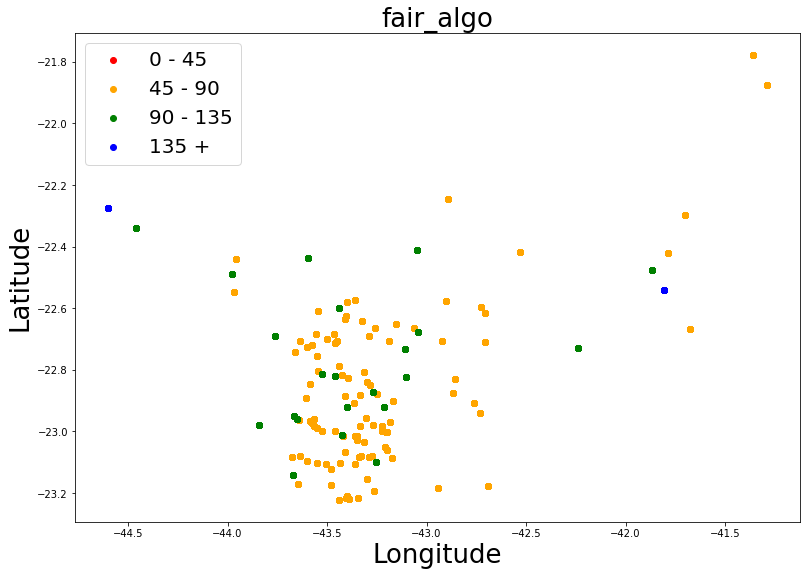

In [ ]:
# driver_income_dfs right now is a dictionary
fair_algo_income_df = pd.DataFrame(driver_income_dfs['fair_algo'])
scatter_income(fair_algo_income_df, 'fair_algo')

0 45
45 90
90 135
135 100000
[  4.   4.   4. ... 164. 164. 164.]


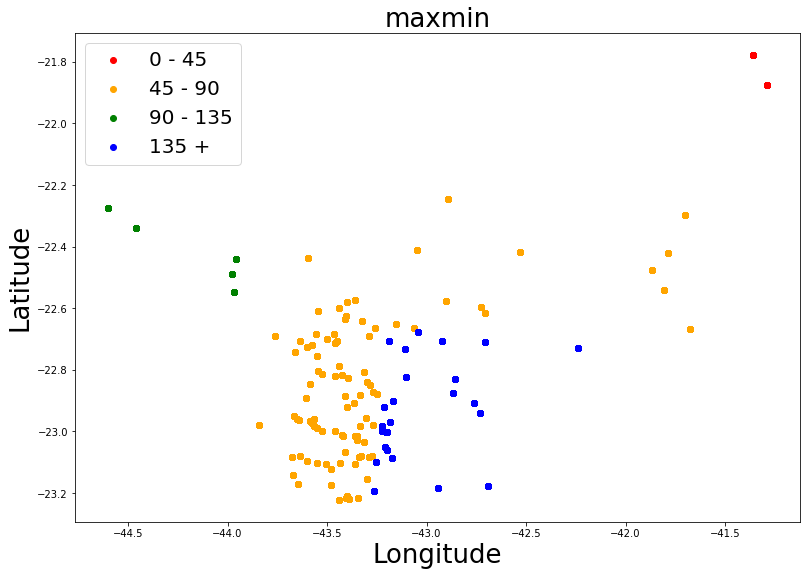

In [ ]:
maxmin_income_df = pd.DataFrame(driver_income_dfs['vanilla_maxmin'])
scatter_income(maxmin_income_df, 'maxmin')

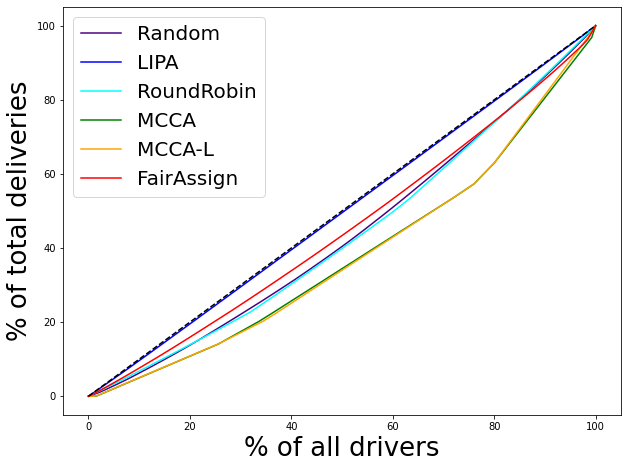

In [ ]:
lorenz(income_arrs, Name_dis_types, colors)

###################################################################################################################

In [ ]:
new_drivers = driver_generation(random_seed) 
print(new_drivers)

def L2Distance(data):

  transposed = np.expand_dims(data, axis = 1)
  distance = np.power(data - transposed, 2)
  distance = np.power(np.abs(distance).sum(axis = 2), 0.5) 
#   distance = distance*110

  return distance

dist_matrix = L2Distance(new_drivers)
print(dist_matrix[0])
print(dist_matrix[:][0])

Number of Drivers: 143
[[-23.03980709 -44.56499007]
 [-22.97110173 -44.15136083]
 [-23.11457499 -43.63275613]
 [-23.10672966 -43.4961244 ]
 [-22.99711814 -43.37293644]
 [-22.9308963  -43.16175514]
 [-22.99594437 -43.62901378]
 [-23.01409233 -43.34761958]
 [-22.96332301 -43.54994278]
 [-23.13263235 -43.3865159 ]
 [-23.0432008  -43.29690434]
 [-23.15818232 -43.23798838]
 [-23.11837731 -43.5995675 ]
 [-22.97663138 -43.41912026]
 [-23.08612972 -43.53252282]
 [-23.12048891 -43.25934469]
 [-23.16500932 -43.15365819]
 [-22.90099052 -43.6499407 ]
 [-23.18466186 -43.34905164]
 [-23.08083795 -43.55214076]
 [-22.93498729 -43.21474139]
 [-23.10702652 -43.58572956]
 [-22.94270977 -43.38260423]
 [-23.160897   -43.36409792]
 [-23.16583617 -43.39294468]
 [-23.00212926 -43.51305416]
 [-22.99177703 -43.48920429]
 [-23.12073428 -43.60720778]
 [-23.02080998 -43.42422763]
 [-23.06050526 -43.47691236]
 [-22.99810127 -43.59577022]
 [-23.00635999 -43.33218164]
 [-23.02392354 -43.37735226]
 [-23.155843   -43.4

In [ ]:
import numpy as np

pt1 = [-23.03980709, -44.56499007]
pt2 = [-22.97110173, -44.15136083]

# Euclidean distance between pt1 and pt2
dx = pt1[0] - pt2[0]
dy = pt1[1] - pt2[1]

e_dist = np.sqrt(dx**2 + dy**2)
print("Euclidean Distance:", e_dist)

# Haversine distance 
def haversine_distance(lat1, lon1, lat2, lon2):
    p = np.pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p) * np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p))/2
    return 12742 * np.arcsin(np.sqrt(a))

h_dist = haversine_distance(pt1[0], pt1[1], pt2[0], pt2[1])
print("Haversine Distance:", h_dist)

print("Euclidean Distance multiplied by 110:", e_dist*110)

Euclidean Distance: 0.41929652356739866
Haversine Distance: 43.01927724582306
Euclidean Distance multiplied by 110: 46.12261759241385


-------------------------------------------------------------------------------------------------------------------

Getting the FFCs to which each driver gets assigned over the span of 30 days.

In [ ]:
len(driver_ffc_maps)

300

In [ ]:
relevant_cols = ['ffc_index', 'driver_index']
driver_ffc_maps[0][relevant_cols].head()

,ffc_index,driver_index
0,6,0
1,6,1
2,3,2
3,1,3
4,6,4


In [ ]:
data_frames = [x[relevant_cols] for x in driver_ffc_maps]

In [ ]:
# from functools import reduce
# df_merged = reduce(lambda left, right: pd.merge(left, right, on=['driver_index']), data_frames).fillna('void')
df_merged = pd.concat(data_frames)

In [ ]:
final_ = pd.concat(data_frames)
final_gb = final_.groupby('driver_index')

In [ ]:
driver_ffc_all = []
for d_id in driver_ffc_maps[0].index:
    # ffcs to which driver 'd_id' was assigned over all 30 days:
    all_ffcs = final_gb.get_group(d_id)['ffc_index'].values
    driver_ffc_all.append(all_ffcs)
print(driver_ffc_all)

[array([6, 1, 0, 3, 0, 3, 1, 3, 6, 6, 6, 6, 6, 0, 0, 1, 1, 1, 6, 3, 0, 0,
       0, 1, 1, 1, 1, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 6, 0, 3,
       1, 6, 6, 3, 0, 3, 0, 6, 6, 0, 6, 0, 6, 0, 6, 6, 6, 0, 6, 0, 0, 0,
       0, 1, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 3, 0, 6, 6, 1, 6, 1, 1,
       0, 6, 0, 3, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 0, 6, 0, 6, 6, 6, 0, 3, 6, 6, 6, 6, 6, 3, 6, 0, 6, 1, 6,
       6, 1, 0, 1, 1, 3, 6, 1, 6, 6, 6, 1, 3, 0, 1, 1, 1, 0, 0, 6, 3, 1,
       1, 6, 0, 1, 0, 6, 3, 3, 1, 6, 6, 3, 3, 6, 6, 6, 0, 3, 0, 3, 1, 6,
       3, 1, 6, 6, 6, 6, 0, 0, 6, 1, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6,
       6, 3, 6, 1, 3, 6, 1, 6, 6, 6, 6, 1, 6, 3, 6, 1, 6, 6, 6, 1, 0, 6,
       6, 6, 0, 6, 6, 3, 3, 1, 1, 6, 1, 6, 0, 3, 6, 3, 6, 0, 6, 1, 6, 6,
       3, 6, 6, 1, 6, 0, 0, 9, 1, 6, 1, 6, 6, 1, 6, 6, 0, 1, 1, 0, 6, 6,
       9, 6, 3, 6, 0, 6, 3, 6, 1, 0, 6, 6, 6, 1]),

In [ ]:
driver_ffc_df = driver_ffc_maps[0][relevant_cols].copy()
driver_ffc_df['ffcs'] = driver_ffc_all 
driver_ffc_df['ffc_span'] = driver_ffc_df['ffcs'].apply(lambda x:np.unique(x))
driver_ffc_df['num_ffc_span'] = driver_ffc_df['ffc_span'].apply(lambda x:len(x))

driver_ffc_df.head()

,ffc_index,driver_index,ffcs,ffc_span,num_ffc_span
0,6,0,"[6, 1, 0, 3, 0, 3, 1, 3, 6, 6, 6, 6, 6, 0, 0, ...","[0, 1, 3, 6, 9]",5
1,6,1,"[6, 0, 1, 0, 6, 1, 6, 6, 1, 0, 1, 6, 6, 6, 1, ...","[0, 1, 3, 6, 7, 9]",6
2,3,2,"[3, 6, 6, 6, 6, 6, 0, 1, 6, 1, 6, 1, 1, 1, 3, ...","[0, 1, 3, 6, 7, 9]",6
3,1,3,"[1, 1, 1, 6, 1, 6, 6, 6, 1, 6, 1, 6, 1, 6, 1, ...","[0, 1, 3, 6, 7, 9]",6
4,6,4,"[6, 6, 3, 1, 1, 1, 6, 9, 6, 3, 6, 3, 6, 6, 6, ...","[0, 1, 3, 6, 7, 9]",6


In [ ]:
print("avg number of zones to which a driver is assigned over 30 days:", np.mean(driver_ffc_df['num_ffc_span']))

avg number of zones to which a driver is assigned over 30 days: 7.146853146853147


In [ ]:
np.min(driver_ffc_df['num_ffc_span']), np.max(driver_ffc_df['num_ffc_span'])

(5, 10)

In [ ]:
# Print all the result
All_Income = pd.DataFrame({'Dist Type':Name_list,'Gini': Gini_Index_List, 'Avg Dist':Avg_Distance_List,'Income_Gap':Income_Gap_List,'spatial_index':spatial_inequality_list,'Income_sum':Income_sum_lis})
All_Income = All_Income.replace("Low Income Distribution","Robinhood") # just as cool line! no meaning

# configParser.read(configFilePath)
print("State: ",configParser.get('dataset-generation','state'))
# print("num_training_days: ",num_training_days)
# print("num_testing_days: ",num_testing_days)
# print("Equal_to_or_not: ",configParser.get('dataset-generation','equal_to'))
print("num_ffc_center: ",configParser.get('dataset-generation','num_ffc_center'))
print("Grid Size: ",configParser.get('dataset-generation','grid_length'),configParser.get('dataset-generation','grid_width'))
print("Fair Distance: ",configParser.get('fairness-constraint','fair_distance'))
# print("Alpha_fair: ",configParser.get('fairness-constraint','alpha_fair'))
print("Alpha_fair: ",alpha_fair)
print("number_of_runs: ",configParser.get('dataset-generation','number_of_runs'))
print()
print("Avg Num of Drivers: ",np.mean(np.array(num_drivers)))
print() 

print("#################################### FINAL RESULTS #######################################################")
print("[ Mean for each Dist Type ] :\n")
print(All_Income.groupby('Dist Type').mean().round(4))
print()
print("[ Max for each Dist Type ] :\n")
print(All_Income.groupby('Dist Type').max())
print()
print("[ Min for each Dist Type ] :\n")
print(All_Income.groupby('Dist Type').min())
print()

State:  RJ
num_ffc_center:  10
Grid Size:  7 7
Fair Distance:  0.60
Alpha_fair:  2.0
number_of_runs:  10

Avg Num of Drivers:  123.1

#################################### FINAL RESULTS #######################################################
[ Mean for each Dist Type ] :

              Gini  Avg Dist  Income_Gap  spatial_index  Income_sum
Dist Type                                                          
FairAssign  0.1002     0.399       0.298         0.1476   10132.502
LIPA        0.0273     0.531       0.086         0.0510    6694.142
MCCA        0.2452     0.208       0.939         0.4655   10142.688
MCCA-L      0.2346     0.211       0.900         0.4319   10145.602
Random      0.1349     0.826       0.579         0.2027   10132.683
RoundRobin  0.1348     0.828       0.548         0.1897   10132.774

[ Max for each Dist Type ] :

             Gini  Avg Dist  Income_Gap  spatial_index  Income_sum
Dist Type                                                         
FairAssign  0.124  